In [118]:
#importing libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [119]:
#Read the csv data file into a panda dataframe (df) for holding data
#df: panda dataframe
df = pd.read_csv('sentiment-bitcoin.csv')
df = df.rename(columns = {'Unnamed: 0': 'timestamp'})
df.head() #head: Print the first few entries from the data frame

,timestamp,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
0,2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00
1,2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48
2,2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93
3,2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78
4,2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00


## Simple metrics study

In [120]:
#A break above resistance is considered to be bullish while a break below 
#support is considered to be bearish. The Principle of Polarity states that 
#once a Resistance level is breached, it changes its nature and becomes 
#Support the next time it is approached.
df['Polarity'].describe() #'describe' the 'Polarity' feature

count    294.000000
mean       0.099534
std        0.012114
min        0.051695
25%        0.091489
50%        0.099198
75%        0.106649
max        0.135088
Name: Polarity, dtype: float64

In [121]:
#Sensitivity is the extent of the response of a financial instrument to changes 
#in its underlying factors. Such factors continuously influence financial 
#instruments, such as stocks and bonds. Sensitivity accounts for all the factors
#that negatively or positively impact a given financial instrument's value.
df['Sensitivity'].describe() #'describe' the 'Sensitivity' feature

count    294.000000
mean       0.214141
std        0.014940
min        0.174330
25%        0.203450
50%        0.214756
75%        0.223910
max        0.271796
Name: Sensitivity, dtype: float64

In [122]:
#http://gambiste.com/index.php/2017/09/27/twitter-volume-spikes-analysis-application-trading/
df['Tweet_vol'].describe() #'describe' the 'Tweet_vol' feature

count      294.000000
mean      4691.119048
std       1048.922706
min       2998.000000
25%       3878.750000
50%       4452.000000
75%       5429.750000
max      10452.000000
Name: Tweet_vol, dtype: float64

In [123]:
df['Close_Price'].describe() #'describe' the 'Close_Price' feature

count     294.000000
mean     6920.150000
std       565.424866
min      6149.110000
25%      6283.497500
50%      7281.975000
75%      7424.560000
max      7750.090000
Name: Close_Price, dtype: float64

## Detecting outliers / sudden spikes in our close prices

In [124]:
#detect: function which identifies and return index of values(closing prices) 
#that are greater than treshold(absolute)
#e.g for Z-score, it will return values lying outside (mean+/-treshold*std)
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

In [125]:
#signal: # a copy of the the 'Close_price' feature
#std_signal: Normalized (Z-score) for Closing price
#s: conversion of closing feature to a list like data structure(panda series)
signal = np.copy(df['Close_Price'].values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
s = pd.Series(std_signal)
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count    2.940000e+02
mean     2.223467e-15
std      1.001705e+00
min     -1.365972e+00
25%     -1.127892e+00
50%      6.410081e-01
75%      8.936113e-01
95%      1.375160e+00
max      1.470319e+00
dtype: float64

In [126]:
#Identify the standardized closing prices that are 
#outliers (lie outside mean+/-treshold*sigma)
#std_signal: signal(close_price) standaridized to mean 0 and variance 1)
outliers = detect(std_signal, 1.3) #treshold = 1.3

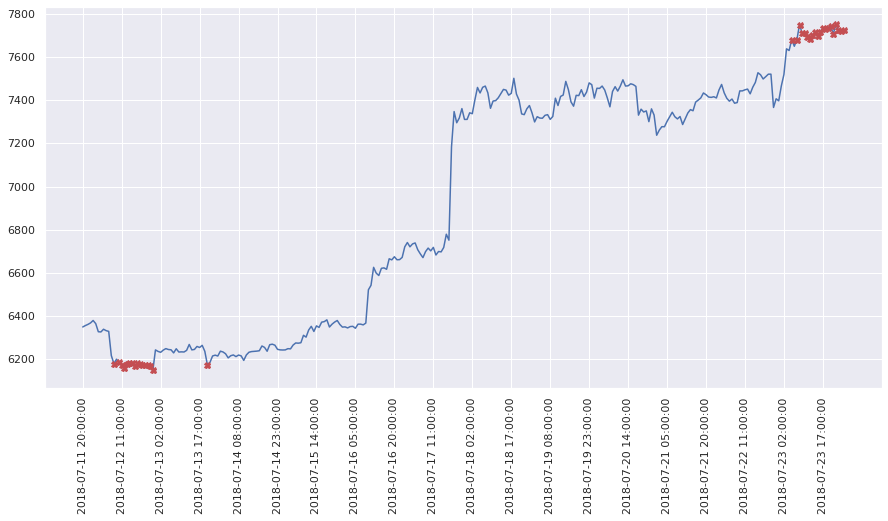

In [127]:
#Plot the closing price(signal) and mark the outliers from the standardized
#closing price identified earlier (outliers)
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal)
plt.plot(
    np.arange(len(signal)),
    signal,
    'X',
    label = 'outliers',
    markevery = outliers, 
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.show()
#The red points in plot below are outside mean+/-treshold*sigma, (outside 99%)

In [128]:
#Normalize(min-max) the data with features: polarity, sensitivity and closing price
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler().fit(df[['Polarity', 'Sensitivity', 'Close_Price']])
scaled = minmax.transform(df[['Polarity', 'Sensitivity', 'Close_Price']])

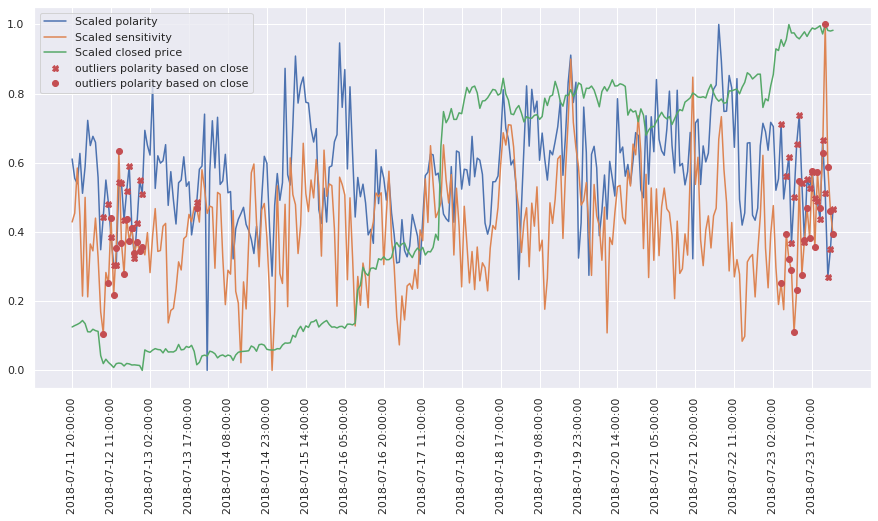

In [129]:
plt.figure(figsize = (15, 7))
#plot the min-max normalized polarity, sensitivity and closing price
plt.plot(np.arange(len(signal)), scaled[:, 0], label = 'Scaled polarity')
plt.plot(np.arange(len(signal)), scaled[:, 1], label = 'Scaled sensitivity')
plt.plot(np.arange(len(signal)), scaled[:, 2], label = 'Scaled closed price')

#mark the polarity values for outliers detected on 'standardized' closing prices
plt.plot(
    np.arange(len(signal)),
    scaled[:, 0],
    'X',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)

#mark the sensitivity values for outliers detected on 'standardized' closing prices
plt.plot(
    np.arange(len(signal)),
    scaled[:, 1],
    'o',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.legend()
plt.show()

Doesnt show much from trending, how about covariance correlation?

## Pearson correlation

In [130]:
df.corr()

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
Polarity,1.000000,0.380350,-0.167573,0.179056,0.176277,0.180088,-0.062868,-0.052646,0.178456
Sensitivity,0.380350,1.000000,0.053903,0.194763,0.200611,0.190222,0.097124,0.112425,0.193203
Tweet_vol,-0.167573,0.053903,1.000000,0.237185,0.262207,0.234330,0.541112,0.545850,0.250448
Open,0.179056,0.194763,0.237185,1.000000,0.997128,0.998799,0.217478,0.277600,0.997217
High,0.176277,0.200611,0.262207,0.997128,1.000000,0.996650,0.270551,0.329816,0.998816
Low,0.180088,0.190222,0.234330,0.998799,0.996650,1.000000,0.202895,0.263863,0.998058
Volume_BTC,-0.062868,0.097124,0.541112,0.217478,0.270551,0.202895,1.000000,0.995873,0.243875
Volume_Dollar,-0.052646,0.112425,0.545850,0.277600,0.329816,0.263863,0.995873,1.000000,0.303347
Close_Price,0.178456,0.193203,0.250448,0.997217,0.998816,0.998058,0.243875,0.303347,1.000000


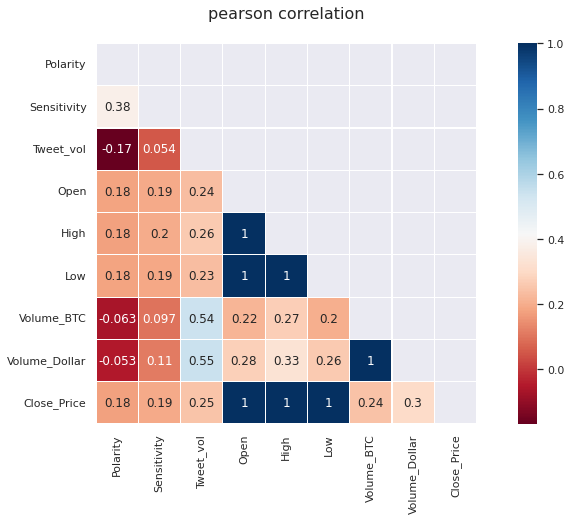

In [131]:
#Simple heatmap plotting the correlation in data df.corr()
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 7))
plt.title('pearson correlation', y = 1.05, size = 16)

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df.corr(),
    mask = mask,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()
#e.g. correlation between closing price and polarity is only 0.18. 
#which probably explains why outliers identified based on closing price 
#doesn't show up on extreme values in polarity.

In [132]:
def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += 1
        #df = pd.concat([df, dfn], axis = 1, join_axes = [df.index])
        df = pd.concat([df, dfn], axis = 1)
        df.shape
    return df


In [133]:
df_new = df_shift(df, lag = 42, start = 7, skip = 7)
(df.shape, df_new.shape)

((294, 10), (294, 70))

In [134]:
df.describe()

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,2.940000e+02,294.000000
mean,0.099534,0.214141,4691.119048,6915.349388,6946.782925,6889.661054,329.745034,2.328086e+06,6920.150000
std,0.012114,0.014940,1048.922706,564.467674,573.078843,559.037540,344.527625,2.508128e+06,565.424866
min,0.051695,0.174330,2998.000000,6149.110000,6173.610000,6072.000000,22.000000,1.379601e+05,6149.110000
25%,0.091489,0.203450,3878.750000,6285.077500,6334.942500,6266.522500,129.230000,8.412214e+05,6283.497500
50%,0.099198,0.214756,4452.000000,7276.845000,7311.380000,7245.580000,223.870000,1.607008e+06,7281.975000
75%,0.106649,0.223910,5429.750000,7422.957500,7457.202500,7396.427500,385.135000,2.662185e+06,7424.560000
max,0.135088,0.271796,10452.000000,7754.570000,7800.000000,7724.500000,2640.490000,1.912641e+07,7750.090000


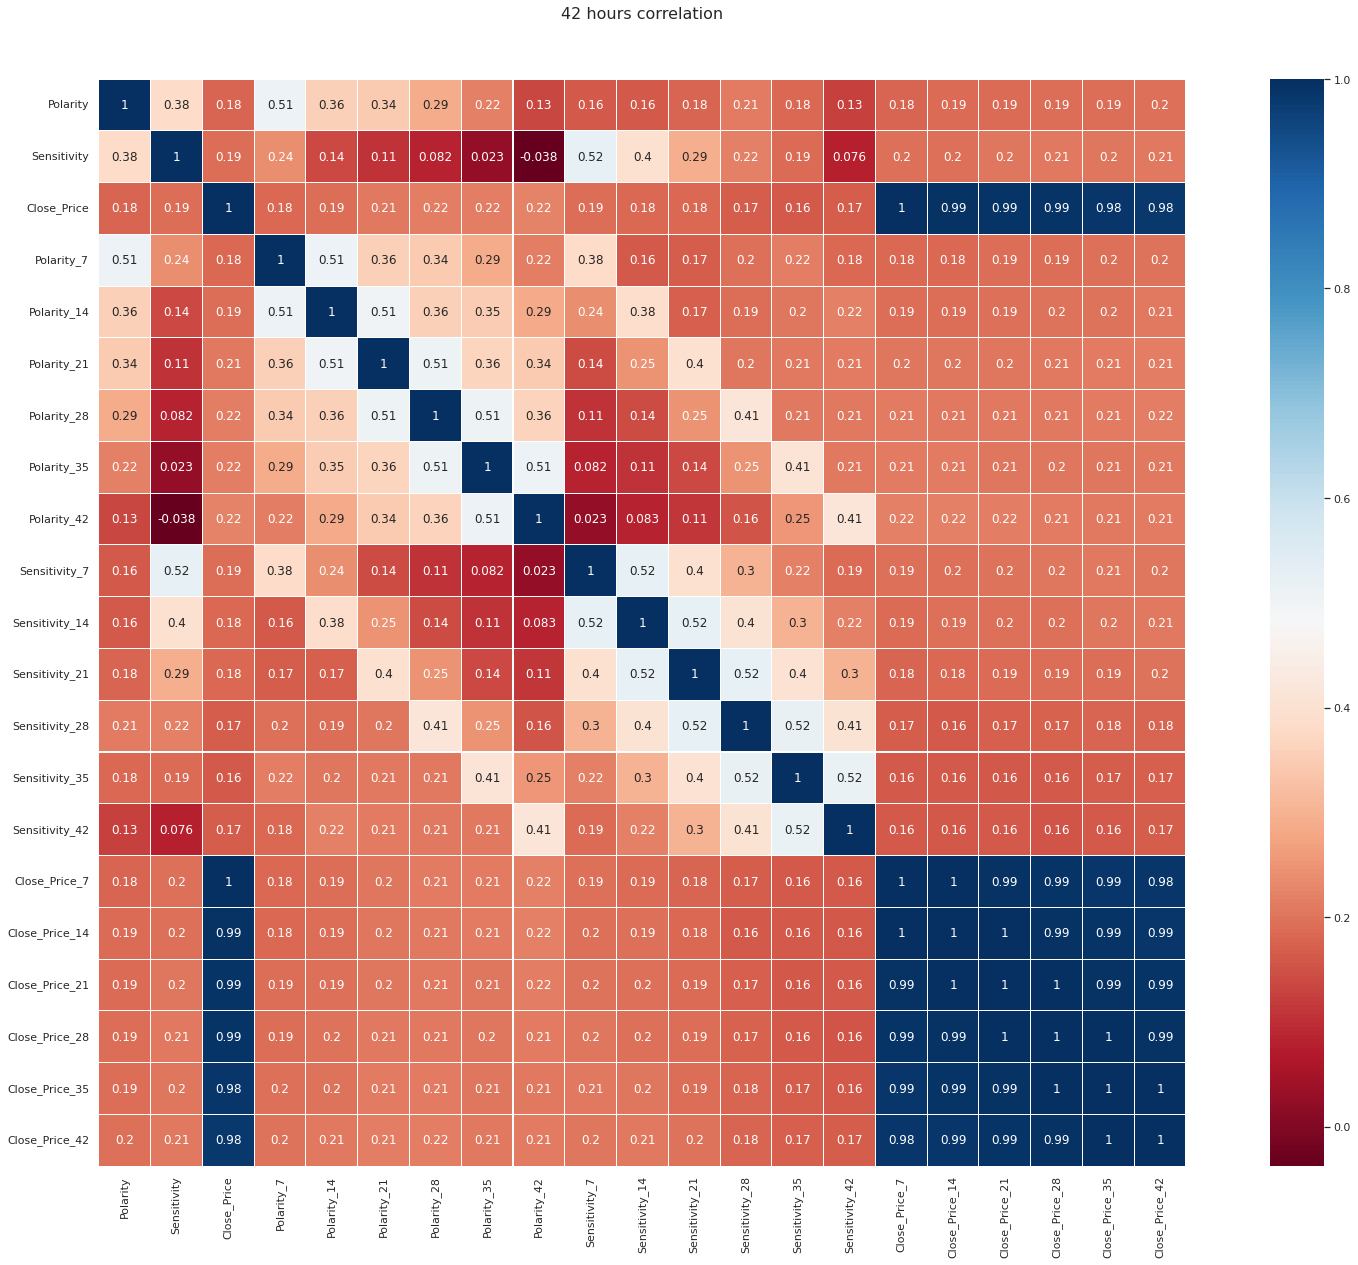

In [135]:
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 20))
ax = plt.subplot(111)
plt.title('42 hours correlation', y = 1.05, size = 16)
selected_column = [
    col
    for col in list(df_new)
    if any([k in col for k in ['Polarity', 'Sensitivity', 'Close']])
]

sns.heatmap(
    df_new[selected_column].corr(),
    ax = ax,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

## How about we check trends from moving average? i chose 7, 14, 30 hours

I think i had too much playing daily trending data

In [136]:
#Function to calculate moving averge of a variable signal over a 'period' duration.
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(signal[i - period : i].mean())
    return buffer

In [137]:
#Compute moving average (calculated over different durations)
signal = np.copy(df['Close_Price'].values)
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_30 = moving_average(signal, 30)

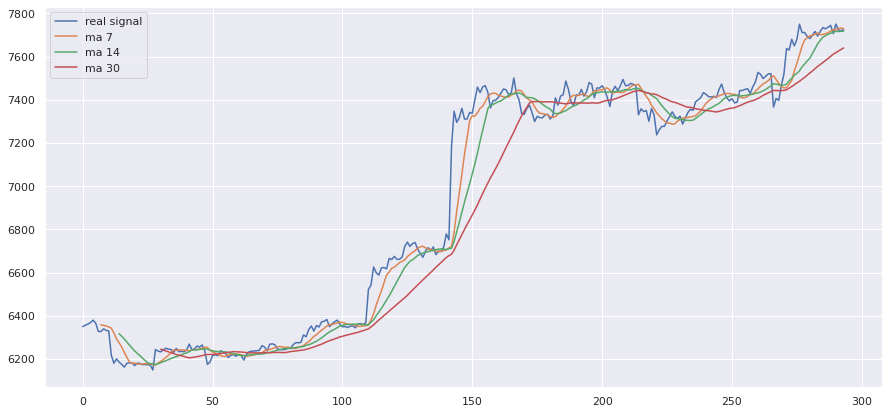

In [138]:
#Plot moving average (calculated over different durations)
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.plot(np.arange(len(signal)), ma_7, label = 'ma 7')
plt.plot(np.arange(len(signal)), ma_14, label = 'ma 14')
plt.plot(np.arange(len(signal)), ma_30, label = 'ma 30')
plt.legend()
plt.show()

Trends gonna increase anyway!

## Now deep learning LSTM

In [139]:
#Some parameters for the LSTM based model
num_layers = 1 #num of LSTM cells placed sequentially.
learning_rate = 0.005
#https://tung2389.github.io/coding-note/unitslstm
size_layer = 128 #num of units in a lstm cell
timestamp = 5  #works as batch size for data
epoch = 500  
dropout_rate = 0.6

In [140]:
dates = pd.to_datetime(df.iloc[:, 0]).tolist()

In [141]:
#Some of the calls are replaced with tf.compact.v1.* to deal with
#compatibility issue with more recent version of TensorFlow.
class Model:
    def __init__(
        self, learning_rate, num_layers, size, size_layer, forget_bias = 0.8
    ):

        #lstm cell, rnn cell, placeholder for data/var, dropout, hidden layers,
        #dynamci_rnn, dense, cost, optimizer.

        #return lstm cell with 'size_layer' units.
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        #create rnn cell with 'num_layers' of lstm cells.
        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        
        #placeholder for variable that has to be fed (provided values) by 
        #'feed_dict' in sess.run call during training/predictions.
        #size: number of features.
        tf.compat.v1.disable_eager_execution() #
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size)) #
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, size)) #
        
        #DropoutWrapper: Adding dropout to input and outputs of a given cell
        #Here 'drop' is the RNN cell
        drop =tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )

        #placeholder for hidden_layer
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        
        #outputs: The RNN output tensor
        #state: final state of model (weights etc)
        #dynamic_rnn: Creates a recurrent neural network specified by RNNCell cell.
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        
        #Interface for densely/fully connected layer: serves as output layer
        self.logits = tf.compat.v1.layers.dense(
            self.outputs[-1], #last state/layer
            size,   #dimensionality of the output space: 
            #kernel_initializer: initializer for weights etc for dense layer
            kernel_initializer = tf.compat.v1.glorot_uniform_initializer(), 
        )

        #mean-squared error?
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        
        #Optimizer: Adam
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [142]:
#Min-max normalized stock data with 4 fetures only for deep learning model
minmax = MinMaxScaler().fit(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)
df_scaled = minmax.transform(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head() #display first few values

,0,1,2,3
0,0.611105,0.429055,0.181916,0.125479
1,0.555312,0.454335,0.192380,0.129527
2,0.539534,0.584943,0.131741,0.132931
3,0.627175,0.445375,0.111618,0.137210
4,0.511893,0.214693,0.134156,0.144218


In [143]:
tf.compat.v1.reset_default_graph() 
#Create a model instance
modelnn = Model(
    learning_rate, num_layers, df_scaled.shape[1], size_layer, dropout_rate
)


#sess.run: (documentation) This method runs one "step" of TensorFlow computation, 
#by running the necessary graph fragment to execute every Operation 
#and evaluate every Tensor in fetches, substituting the values in feed_dict 
#for the corresponding input values.

#'run' below is like run to initialize. 
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

<ipython-input-141-34c7ab743bb3>:13: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
<ipython-input-141-34c7ab743bb3>:47: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


We need to scale our data between 0 - 1 or any scaled you wanted, but must not less than -1 and more than 1, because LSTM is using tanh function, squashing high values can caused gradient vanishing later

In [144]:
#Model training with epoch=500 (500 loops over data)
#and in batch size of 5
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    #loop in batches of 5
    for k in range(0, (df_scaled.shape[0] // timestamp) * timestamp, timestamp):
        #Note: if batch_x is from k till k+5, batch_y is from k_1 till k+6
        #If batch_x is treated as input, we want batch_y with that '1' extra 
        #value (prediction)
        batch_x = np.expand_dims(
            df_scaled.iloc[k : k + timestamp].values, axis = 0
        )
        batch_y = df_scaled.iloc[k + 1 : k + timestamp + 1].values

        #Initiate model training for this batch
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state #model state (weights etc)
        total_loss += loss #accumulate loss
    total_loss /= df.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.00933566355499728
epoch: 200 avg loss: 0.007242311787759435
epoch: 300 avg loss: 0.0057202178888536735
epoch: 400 avg loss: 0.006318484802312892
epoch: 500 avg loss: 0.005573670568490593


In [145]:
#future_count: extra predictions (30), apart from given data(296 instances)
def predict_future(future_count, df, dates, indices = {}):
    date_ori = dates[:]
    cp_df = df.copy() #make a copy of the data

    #output_predict: will eventually have the prediced values for 4 features
    output_predict = np.zeros((cp_df.shape[0] + future_count, cp_df.shape[1]))

    #initiate the first value as it is, rest comes from prediction
    output_predict[0] = cp_df.iloc[0]
    upper_b = (cp_df.shape[0] // timestamp) * timestamp 
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    #process prediction in batch sizes
    for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
        #get prediction for this batch in out_logits
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    cp_df.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        #store the prediction in 'output_predict' data structure.
        output_predict[k + 1 : k + timestamp + 1] = out_logits

        #prediction for leftover (not covered in multiples of 5): verify
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    cp_df.iloc[upper_b:], axis = 0
                ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : cp_df.shape[0] + 1] = out_logits
    cp_df.loc[cp_df.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(hours = 1))
    if indices:
        for key, item in indices.items():
            cp_df.iloc[-1, key] = item
    
    #next 30(future_count) predictions
    for i in range(future_count - 1):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(cp_df.iloc[-timestamp:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        #store the additional (future_count) predictions in output_predict
        output_predict[cp_df.shape[0]] = out_logits[-1]
        cp_df.loc[cp_df.shape[0]] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(hours = 1))
        if indices:
            for key, item in indices.items():
                cp_df.iloc[-1, key] = item
    return {'date_ori': date_ori, 'df': cp_df.values}

Define some smoothing, using previous value as an anchor

In [146]:
#function to smooth out the values
#if weight=0.5, then current_val = 0.5*curr + 0.5*prev
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [147]:
#Get prediction for existing + 30 next values of P, S, T, C
#note predict_30 is a dictionary and contains time and predicted data
predict_30 = predict_future(30, df_scaled, dates)
predict_30['df'] = minmax.inverse_transform(predict_30['df'])

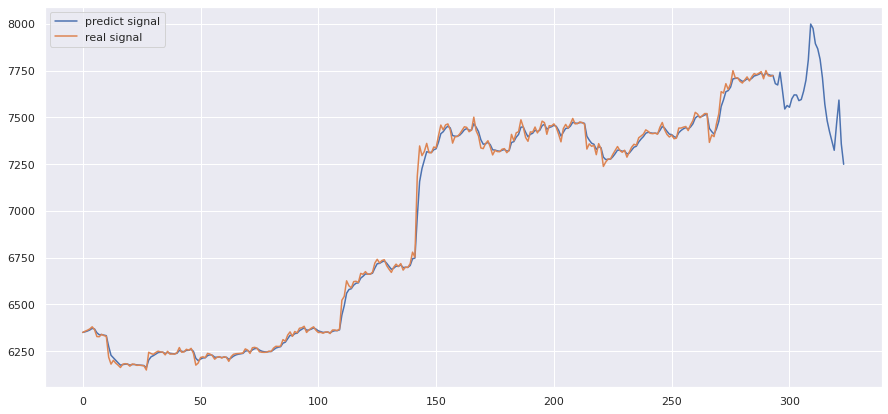

In [148]:
plt.figure(figsize = (15, 7))
plt.plot(
    np.arange(len(predict_30['date_ori'])),
    #use anchor to smooth and plot the only the predicted closing price (-1)
    anchor(predict_30['df'][:, -1], 0.5), 
    label = 'predict signal',
)
#plot the real closing price
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.legend()
plt.show()